# Economic Time Series Analysis Using VAR Model

This is a tutorial on VAR and VEC models that describes the analysis process for multivariate time series:
* We use a three-year data sample of daily S&P 500, gold, and oil prices as a running example. 
* We start with the standard tests (Grainger causality, Dickey-Fuller stationarity) to ensure that the VAR model prerequisite are met. 
* Next, we determine VAR model parameters, fit it, and produce the forecast.
* Finally, we create the second version of the forecast using vector error correction (VEC) model.

## Data
The notebook uses datasets that are availbale in the **tensor-house-data** repository.

## References
1. https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

---
# Step 1: Loading and Filtering the Data

In [1]:
import shutil
import pandas as pd
import numpy as np
import os
from IPython.core.display import HTML
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from datetime import datetime

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests

In [15]:
base_path = '../../../tensor-house-data/time-series'
data_sp500 = pd.read_csv(f'{base_path}/snp-500-daily-1927-2020.csv.zip', compression='zip', parse_dates=['Date'])
data_brent = pd.read_csv(f'{base_path}/oil-brent-usd-daily-1986-2020.csv.zip', compression='zip', parse_dates=['Date'])
data_gld = pd.read_csv(f'{base_path}/gold-usd-daily-1978-2020.csv.zip', compression='zip', parse_dates=['Date'])

In [16]:
data_sp500 = data_sp500[data_sp500['Date'] >= '2016-05-20']
data_sp500 = data_sp500[data_sp500['Date'] <= '2019-05-15']
data_gld = data_gld[data_gld['Date'] >= '2016-05-20']
data_gld = data_gld[data_gld['Date'] <= '2019-05-15']
data_sp500.index = data_sp500['Date']
data_brent.index = data_brent['Date']
data_gld.index = data_gld['Date']

df = pd.DataFrame()
df['sp500'] = data_sp500['Close'].astype(float).round(2)
df['brent'] = data_brent['Price']
df['gld'] = data_gld['Price'].astype(float).round(2)
df = df.asfreq(freq='D') # (1091, 3)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(method='pad', inplace=True)

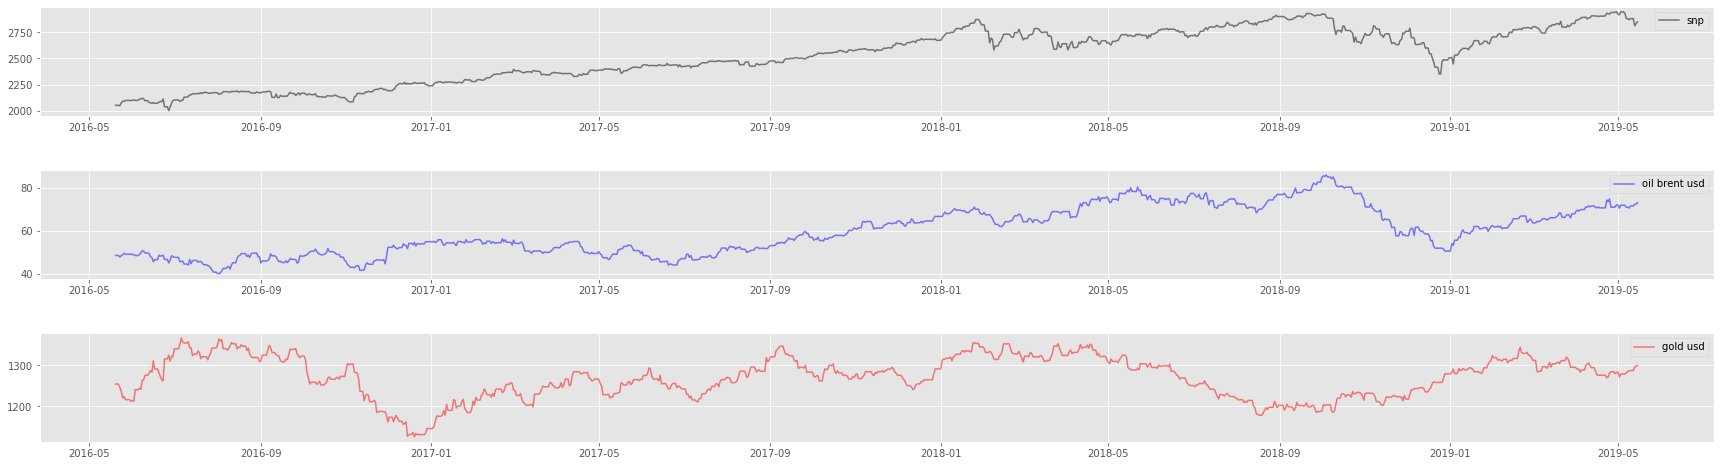

In [90]:
fig, ax = plt.subplots(3, figsize=(30, 8))
ax[0].plot(df['sp500'], color='black', alpha=0.5, label='snp')
ax[1].plot(df['brent'], color='blue', alpha=0.5, label='oil brent usd')
ax[2].plot(df['gld'], color='red', alpha=0.5, label='gold usd')
plt.subplots_adjust(hspace=0.5)
[a.legend() for a in ax]
plt.show()

---
# Step 2: Grainger Causality Test

Let's $y$ and $x$ be stationary time series. To test the null hypothesis that $x$ does not Granger-cause $y$, one first finds the proper lagged values of $y$ to include in a univariate autoregression of $y$:
 
$y_t = a_0 + a_1y_{t-1} + a_2y_{t-2} + ... + a_my_{t-m} + e_t$

Next, the autoregression is augmented by including lagged values of $x$:

$y_t = a_0 + a_1y_{t-1} + a_2y_{t-2} + ... + a_my_{t-m} + b_px_{t-p} + ... + b_qx{t-q} + e_t$

One retains in this regression all lagged values of $x$ that are individually significant according to their t-statistics, provided that collectively they add explanatory power to the regression according to an F-test (whose null hypothesis is no explanatory power jointly added by the $x$'s). In the notation of the above augmented regression, p is the shortest, and q is the longest, lag length for which the lagged value of $x$ is significant. The null hypothesis that $x$ does not Granger-cause $y$ is accepted if and only if no lagged values of $x$ are retained in the regression.

In [28]:
maxlag = 12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))),
                      columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [str(var) + '_x' for var in variables]
    df.index = [str(var) + '_y' for var in variables]
    return df

In [29]:
# Look for products which depend from each other and pick some for our research needs.
grangers_causation_matrix(data=df, variables = df.columns)

,sp500_x,brent_x,gld_x
sp500_y,1.0000,0.6518,0.3257
brent_y,0.0000,1.0000,0.4457
gld_y,0.7856,0.5061,1.0000


It can be seen that brent is slightly causing S&P 500 values, so as gold. Gold and brent costs are also related. S&P 500 doesn't have anything related to brent while it is causing gold.

---
# Step 3: Splitting the Data Into Training and Testing Sets

In [31]:
def print_df(df):
    display(HTML(df.to_html()))

y, x = df.shape
autoreg_window = 7

train_df = df[0:y-autoreg_window]
test_df = df[-autoreg_window:]

print_df(train_df.tail())
print_df(test_df.head())

,sp500,brent,gld
Date,,,
2019-05-04,2945.64,71.95,1278.55
2019-05-05,2945.64,71.95,1278.55
2019-05-06,2932.47,71.95,1278.55
2019-05-07,2884.05,70.98,1281.20
2019-05-08,2879.42,71.09,1285.20


,sp500,brent,gld
Date,,,
2019-05-09,2870.72,70.61,1286.1
2019-05-10,2881.40,71.63,1287.1
2019-05-11,2881.40,71.63,1287.1
2019-05-12,2881.40,71.63,1287.1
2019-05-13,2811.87,72.35,1295.6


---
# Step 4: Stationarity Test

The VAR model requires the input series to be stationary, so we start with the Dickey-Fuller test. 

In [91]:
def test_stationarity(timeseries, rolling_window=7):
    
    # Rolling statistics
    rolmean = timeseries.rolling(window = rolling_window).mean()
    rolstd = timeseries.rolling(window = rolling_window).std()

    fig, (ax, axv) = plt.subplots(2, figsize=(30,4))
    orig = ax.plot(timeseries, color='blue', alpha=0.5, label='Original')
    mean = ax.plot(rolmean, color='red', alpha=0.5, label='Rolling Mean')
    std = axv.plot(rolstd, color='black', alpha=0.5, label = 'Rolling Std')
    ax.set_title('Rolling Mean')
    axv.set_title('Rolling Std')
    for a in (ax, axv):
        a.legend(loc='best')
    plt.show()
    
    # Perform Dickey-Fuller test
    print('Dickey-Fuller Test Results:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Statistic','p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

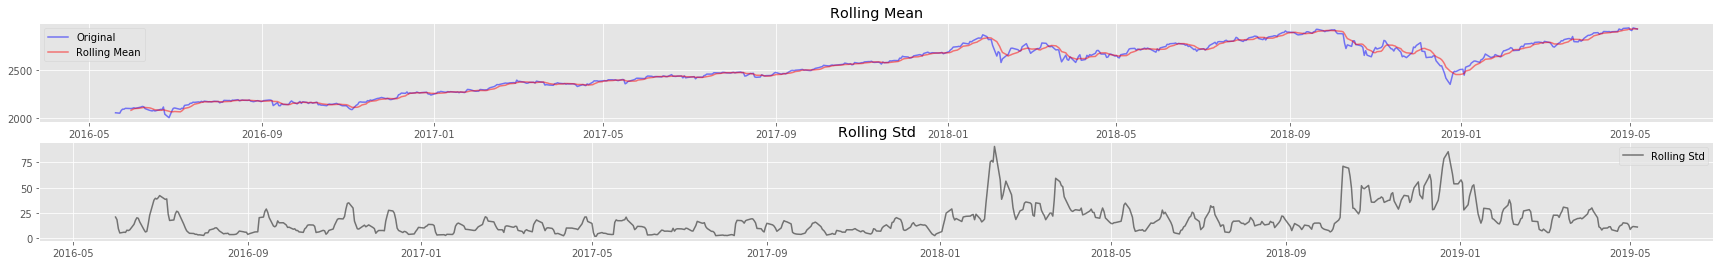

Dickey-Fuller Test Results:
ADF Statistic                   -1.301905
p-value                          0.628300
#Lags Used                       0.000000
Number of Observations Used    743.000000
Critical Value (1%)             -3.439182
Critical Value (5%)             -2.865438
Critical Value (10%)            -2.568846
dtype: float64


In [92]:
test_stationarity(train_df['sp500'])

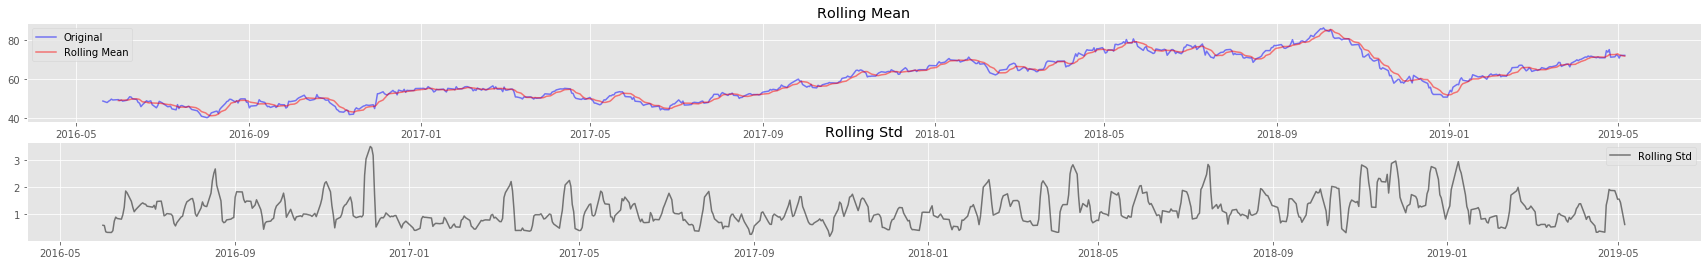

Dickey-Fuller Test Results:
ADF Statistic                   -1.355163
p-value                          0.603573
#Lags Used                       0.000000
Number of Observations Used    743.000000
Critical Value (1%)             -3.439182
Critical Value (5%)             -2.865438
Critical Value (10%)            -2.568846
dtype: float64


In [93]:
test_stationarity(train_df['brent'])

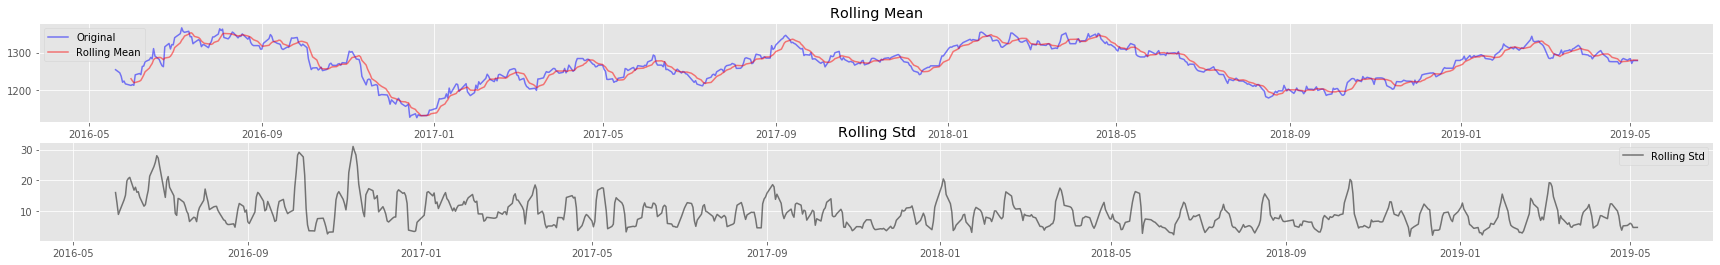

Dickey-Fuller Test Results:
ADF Statistic                   -2.532446
p-value                          0.107778
#Lags Used                       1.000000
Number of Observations Used    742.000000
Critical Value (1%)             -3.439194
Critical Value (5%)             -2.865443
Critical Value (10%)            -2.568848
dtype: float64


In [94]:
test_stationarity(train_df['gld'])

The Dickey-Fuller test confirms that the data is not stationary (which is quite obvious from the visual inspection), so we will do differencing and test for stationarity again.

In [40]:
df_diff = train_df.diff().dropna()

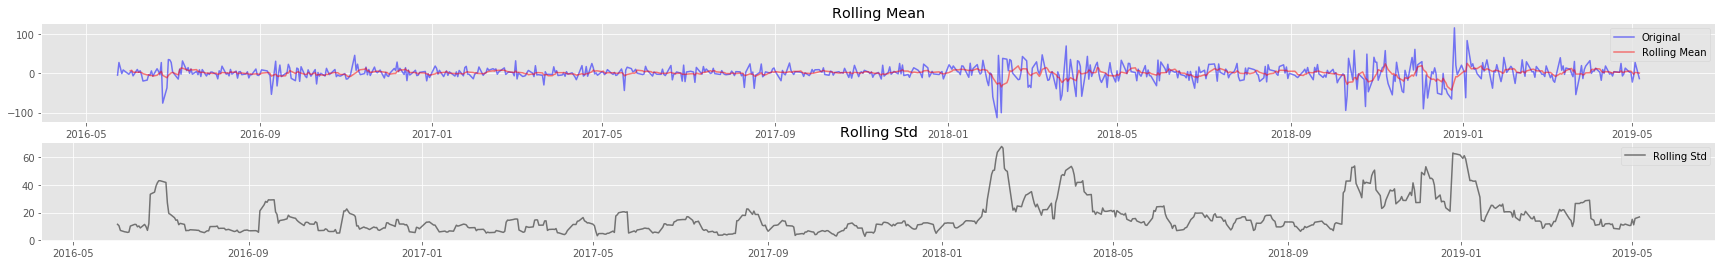

Dickey-Fuller Test Results:
ADF Statistic                 -1.051176e+01
p-value                        1.020220e-18
#Lags Used                     7.000000e+00
Number of Observations Used    7.350000e+02
Critical Value (1%)           -3.439278e+00
Critical Value (5%)           -2.865480e+00
Critical Value (10%)          -2.568868e+00
dtype: float64


In [105]:
test_stationarity(df_diff['sp500'])

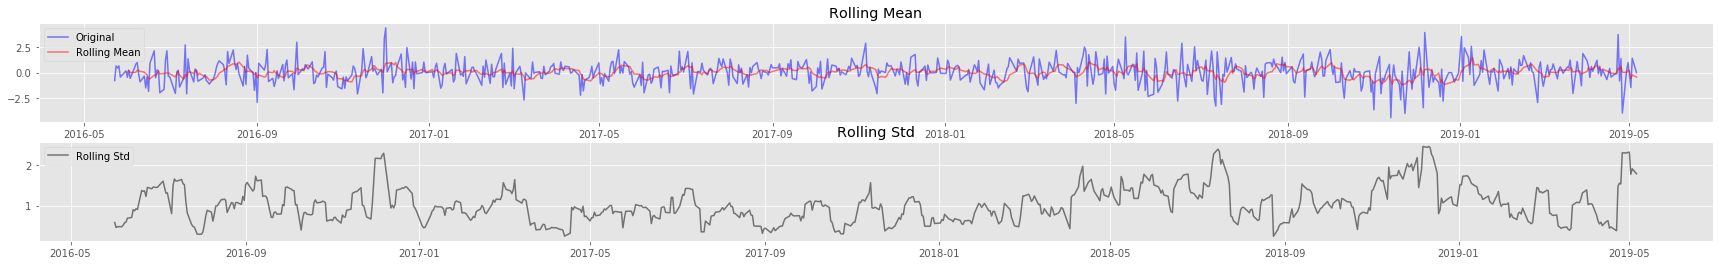

Dickey-Fuller Test Results:
ADF Statistic                  -28.356484
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    742.000000
Critical Value (1%)             -3.439194
Critical Value (5%)             -2.865443
Critical Value (10%)            -2.568848
dtype: float64


In [97]:
test_stationarity(df_diff['brent'])

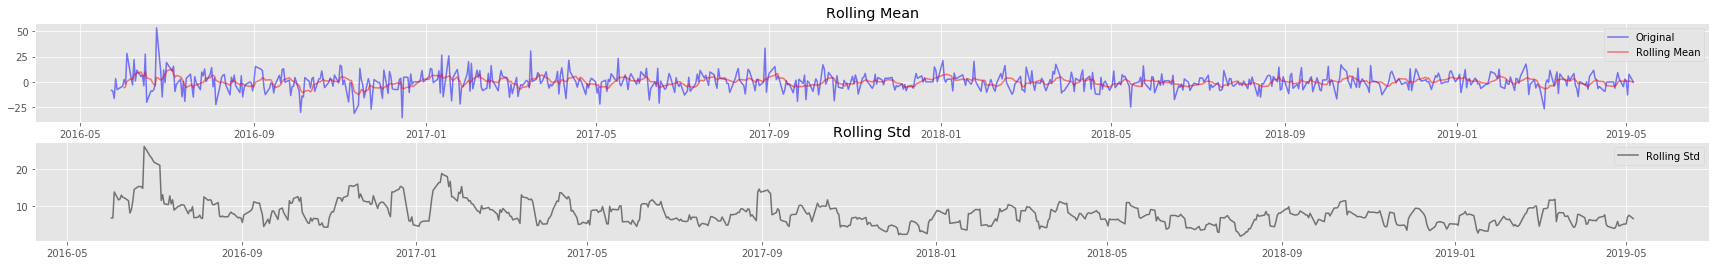

Dickey-Fuller Test Results:
ADF Statistic                  -26.070170
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    742.000000
Critical Value (1%)             -3.439194
Critical Value (5%)             -2.865443
Critical Value (10%)            -2.568848
dtype: float64


In [98]:
test_stationarity(df_diff['gld'])

ADF statitics is now lower than any critical value, so we reject the non-stationarity hypotesis with at least 99% confidence. We will further use the differenciated data for VAR and VEC modeling.

---
# Step 5: Fitting the Model

The next step is deterine the optimal lag order. This can be done by fitting VAR(p) for different $p$ and measuring AIC. We test lag orders of 7, 14, 21, etc. under assumption that the series have strong weekly patterns.

Text(0.5, 0, 'VAR order')

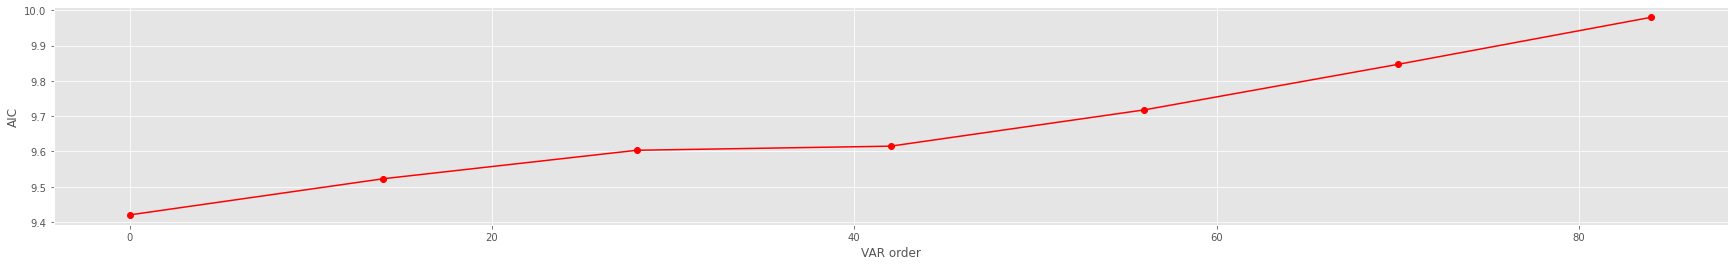

In [41]:
import statsmodels.tsa.api as smt

model_var = smt.VAR(df_diff)
aics = []
orders = []
lag_order_step = 7
for lag_order in np.linspace(0, lag_order_step * 12, lag_order_step, dtype=int):
    result = model_var.fit(lag_order)
    aics.append(result.aic)
    orders.append(lag_order)

aics_df = pd.DataFrame()
aics_df['aics'] = aics
aics_df.index = orders

plt.figure(figsize=(30,4))
plt.plot(aics_df, 'r-o')
plt.ylabel('AIC')
plt.xlabel('VAR order')

Good candidates here are 7, 14, 21 and 28. Having in mind this information and nature of the data, two, three or four weeks of regression are best for further experimenting. Comparing results showed 21 is the best option.

In [42]:
fitted_var = model_var.fit(21)
fitted_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 24, Jul, 2022
Time:                     16:18:13
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    10.4568
Nobs:                     1062.00    HQIC:                   9.89899
Log likelihood:          -9404.37    FPE:                    14172.7
AIC:                      9.55863    Det(Omega_mle):         11890.8
--------------------------------------------------------------------
Results for equation sp500
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.897442         0.530076            1.693           0.090
L1.sp500         -0.040186         0.031984           -1.256           0.209
L1.brent          0.247388         0.579533            0.427           0.669

Durbin-Watson stats is used to analyze the residuals. The test statistics is in the range between 0 and 4, where 0 correspnds to strong positive serial correlation, 4 corresponds to strong negative correlation, and 2 mean no correlation. 

In [43]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(fitted_var.resid)
def adjust(val, length= 6): 
    return str(val).ljust(length)

for col,val in zip(df_diff.columns, out):
    print(adjust(col), ':', round(val, 2))

sp500  : 2.0
brent  : 2.0
gld    : 1.99


---
# Step 6: Forecasting Using VAR Model

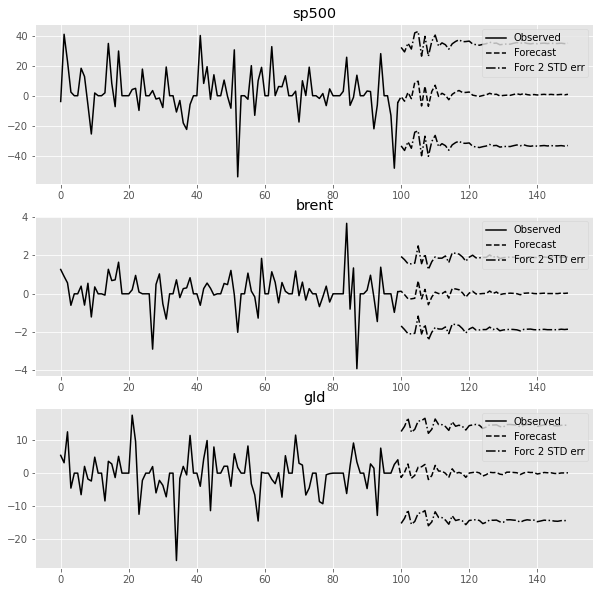

In [44]:
from statsmodels.tsa.vector_ar import plotting

forecast_steps = 50
forecast_alpha = 0.05 # std errror
plot_history = 100 # stesp before the forecast

lag_order = fitted_var.k_ar
forecast_input = df_diff.values[-lag_order:]
fc = fitted_var.forecast(y=forecast_input, steps=forecast_steps)

mid, lower, upper = fitted_var.forecast_interval(forecast_input, forecast_steps, alpha=forecast_alpha)
plotting.plot_var_forc(fitted_var.endog[-plot_history:], mid, lower, upper, names=fitted_var.names, plot_stderr=True);

In [47]:
# Undifferencing. Reverts back the differencing to get the forecast to original scale.
def invert_diff(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    
    for col in columns:        
        df_fc[str(col)] = df_fc[str(col)].cumsum() + df_train[col].iloc[-1]
        
    return df_fc

In [60]:
train_df = df[:-forecast_steps]
test_df = df[-forecast_steps:]

forecast_df = pd.DataFrame(fc, index=df.index[-forecast_steps:], columns=df.columns)
df_results = invert_diff(train_df, forecast_df) 

In [62]:
def plot_forecasts(ground_truth_df, forecast_df):
    fig, ax = plt.subplots(3, 1, sharey=False, figsize=(20, 12))

    plt_spec = [ ('sp500', 'S&P 500 Forecast'),
             ('brent', 'Oil Brent Forecast'),
             ('gld', 'Gold Forecast') ]

    for axi, spec in zip(ax, plt_spec):
        axi.title.set_text(spec[1])
        axi.plot(ground_truth_df[spec[0]], 'k-', label='Ground truth')
        axi.plot(forecast_df[spec[0]], 'r--', label='Forecast')
    
    return fig

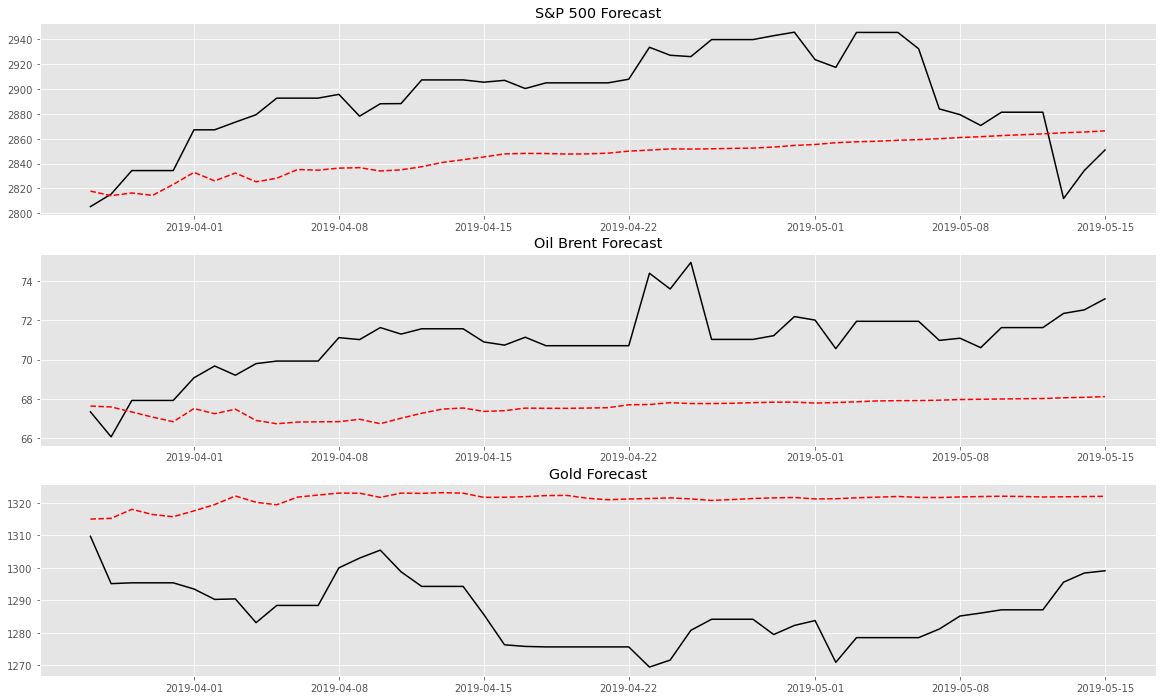

In [63]:
plot_forecasts(test_df, df_results);

---
# Step 7: Testing for Co-integration



Our next step is to test if the series are cointegrated.

In general, if processes $x_t$ and $y_t$ are both $I(1)$ (non stationary), their difference $x_t-y_t$ is also $I(1)$. However, if a linear combinaton $u_t = \alpha_1 x_t + \alpha_2 y_t$ is $I(0)$, it is said that $x_t$ and $y_t$ are cointegrated with cointegration vector $\alpha$. This can be straightforwardly generalized to any number of series in a linear combination. The conintegration property can be used to model interdependent time series more effeciently.

There are several popular tests to check if time series are cointegrated:
1. Basic Engle–Granger
2. Phillips–Ouliaris (an improved Engle-Granger test)
3. Johansen test (also an improved Engle-Geanger test)

We use the third one below to test our inputs.

In [99]:
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,det_order=-1,k_ar_diff=0)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [100]:
cointegration_test(df_diff)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
sp500  ::  1587.77   > 24.2761   =>   True
brent  ::  979.35    > 12.3212   =>   True
gld    ::  477.44    > 4.1296    =>   True


The series are clearly cointegrated. This enables us to use a vector error correction model (VECM).

---
# Step 8: Fitting the VEC Model

Our last step is to fit and evaluate the vector error correction model (VECM) that accounts for cointgeration between the time series. The VECM for input $\mathbf{y}_t$ with cointegrating rank $r$ is specified as:

$$
\nabla \mathbf{y}_t = \mathbf{c} + \mathbf{\Phi}(B)\nabla\mathbf{y}_{t-1} + \beta \mathbf{e}_{t-1} + \mathbf{u}_t
$$

where $\mathbf{e}_t = \mathbf{\alpha}'\mathbf{y_t}$ contains $r$ stationary error corrections, and $\mathbf{\alpha}' = (\mathbf{\alpha}_1, \ldots, \mathbf{\alpha}_r)'$ is a set of cointgeration vecotrs.

In [193]:
forecast_steps = 50
forecast_alpha = 0.05 # std errror
lag_order = fitted_var.k_ar

model_vecm = smt.VECM(endog=train_df, k_ar_diff=lag_order)
fitted_vecm = model_vecm.fit()

forecast, lower, upper = fitted_vecm.predict(steps=forecast_steps, alpha=forecast_alpha)

In [194]:
forecast_vecm_df = pd.DataFrame(forecast, index=df.index[-forecast_steps:], columns=train_df.columns)

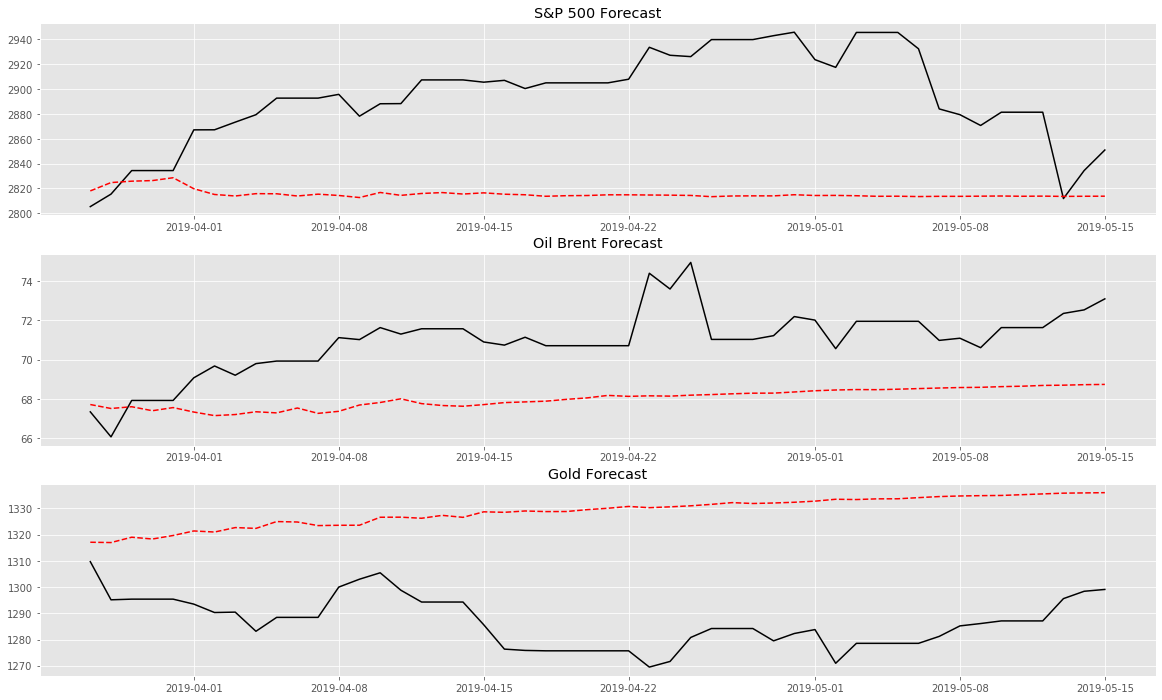

In [195]:
plot_forecasts(test_df, forecast_vecm_df);